<a href="https://colab.research.google.com/github/bchenley/TorchTimeSeries/blob/main/projects/diabetes/GlucoseForecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<a id="introduction"></a>
## Introduction

Blood glucose level forecasting in machine leraning stands as a compelling challenge with significant real-world implications. The task involves predicting future glucose levels based on historical data, enabling proactive management of diabetes and enhancing overall patient care. Accurate glucose forecasting demands sophisticated time series modeling techniques that account for various factors influencing glucose dynamics. This notebook utilizes a package I developed called [TorchTimeSeries](https://github.com/bchenley/TorchTimeSeries) to undertake this task by performing exploratory data analysis, feature engineering, and model selection, training, and testing.

- [Introduction](#introduction)
- [Data Collection](#data-collection)
- [Exploratory Data Analysis](#exploratory-data-analysis)
- [Signal Preprocessing](#signal-preprocessing)
- [Model Selection](#model-selection)
- [Training and Evaluation](#training-and-evaluation)
- [Results](#results)

Publicly available data is obtained from the [Shanghai_T1DM and T2DM datasets](https://figshare.com/articles/dataset/diabetes_datasets_zip/21600933?backTo=/collections/Diabetes_Datasets_ShanghaiT1DM_and_ShanghaiT2DM/6310860). This dataset includes time series data of continuous blood glucose monitoring (CGM), dietary intake (DI), insulin doses (I), and various other variables.

Please download the data files to your desired location. For now, let's assume that you placed the folders in the `/data` directory of your Google Drive:

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Both the T1D and T2D datasets have a file for the time series data and additional excel file that contains summary information about each subject. You may define the paths to you folders here:

In [2]:
t1_path = '/content/drive/MyDrive/data/diabetes datasets/Shanghai_T1DM'
t1_summary_path = '/content/drive/MyDrive/data/diabetes datasets/Shanghai_T1DM_Summary.xlsx'

t2_path = '/content/drive/MyDrive/data/diabetes datasets/Shanghai_T2DM'
t2_summary_path = '/content/drive/MyDrive/data/diabetes datasets/Shanghai_T2DM_Summary.xlsx'

We begin by installing our dependencies. Then we install the TorchTimeSeries package, diabetes project, and relavent libraries:

In [3]:
!pip install torch --quiet
!pip install pytorch_lightning --quiet
!pip install statsmodels --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 727.7/727.7 kB 7.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 764.8/764.8 kB 11.4 MB/s eta 0:00:00


In [4]:
%cd /content
!git clone https://github.com/bchenley/TorchTimeSeries.git

%cd TorchTimeSeries
from TorchTimeSeries.ts_src import *
from TorchTimeSeries.projects.diabetes import * # imports the data collection scripts

/content
Cloning into 'TorchTimeSeries'...
remote: Enumerating objects: 4213, done.
remote: Counting objects: 100% (1021/1021), done.
remote: Compressing objects: 100% (386/386), done.
remote: Total 4213 (delta 707), reused 922 (delta 634), pack-reused 3192
Receiving objects: 100% (4213/4213), 14.10 MiB | 32.97 MiB/s, done.
Resolving deltas: 100% (2983/2983), done.
/content/TorchTimeSeries
Initializing TorchTimeSeries package...
Initializing TorchTimeSeries package...
Done
Done
Initializing Diabetes project...
Done


In [5]:
import torch
import pytorch_lightning as pl
torch.autograd.set_detect_anomaly(True)

import pandas as pd
import numpy as np
import math

import seaborn as sns

from datetime import datetime, timedelta

import matplotlib.pyplot as plt
from matplotlib import cm

from google.colab import drive
import os
import random

from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf

from PIL import Image

<a id="data-collection"></a>
## Data Collection

In this section, we will collect the raw data to prepare it for analysis. To load and collect the data, we run `collect_data`:

In [6]:
data = collect_data(t1_path, t1_summary_path,
                    t2_path, t2_summary_path)

print(f"{len(data)} subjects")

File 1002_2_20210909.xls complete 1/125
File 1006_0_20210114.xlsx complete 2/125
File 1002_1_20210521.xls complete 3/125
File 1006_1_20210209.xlsx complete 4/125
File 1003_0_20210831.xls complete 5/125
File 1005_0_20210522.xls complete 6/125
File 1006_2_20210303.xlsx complete 7/125
File 1009_0_20210803.xls complete 8/125
File 1007_0_20210726.xls complete 9/125
File 1011_0_20210622.xls complete 10/125
File 1010_0_20210915.xls complete 11/125
File 1008_0_20210713.xls complete 12/125
File 1012_0_20210923.xls complete 13/125
File 1001_0_20210730.xlsx complete 14/125
File 1002_0_20210504.xls complete 15/125
File 1004_0_20210425.xls complete 16/125
File 2002_0_20210513.xlsx complete 17/125
File 2000_0_20201230.xlsx complete 18/125
File 2004_0_20211028.xlsx complete 19/125
File 2005_0_20211201.xlsx complete 20/125
File 2001_0_20201102.xlsx complete 21/125
File 2003_0_20210615.xlsx complete 22/125
File 2009_0_20211103.xlsx complete 23/125
File 2008_0_20220118.xlsx complete 24/125
File 2006_0_2

The returned object is a list of dictionaries containing the time series data of the 125 subjects from the two datasets.

There is additional information for each subject, if you are interested exploring futher:

In [7]:
list(data[0])

['diabetes',
 'id',
 'date',
 'iu',
 'iu_h',
 'di',
 'di_g',
 'di_g_r',
 'cgm',
 'cbg',
 'kb',
 'Gender (Female=1, Male=2)',
 'Age (years)',
 'Height (m)',
 'Weight (kg)',
 'BMI (kg/m2)',
 'Smoking History (pack year)',
 'Alcohol Drinking History (drinker/non-drinker)',
 'Type of Diabetes',
 'Duration of Diabetes  (years)',
 'Acute Diabetic Complications',
 'Diabetic Macrovascular  Complications',
 'Diabetic Microvascular Complications',
 'Comorbidities',
 'Hypoglycemic Agents',
 'Other Agents',
 'Fasting Plasma Glucose (mg/dl)',
 '2-hour Postprandial Plasma Glucose (mg/dl)',
 'Fasting C-peptide (nmol/L)',
 '2-hour Postprandial C-peptide (nmol/L)',
 'Fasting Insulin (pmol/L)',
 '2-hour Postprandial Insulin (pmol/L)',
 'HbA1c (mmol/mol)',
 'Glycated Albumin (%)',
 'Total Cholesterol (mmol/L)',
 'Triglyceride (mmol/L)',
 'High-Density Lipoprotein Cholesterol (mmol/L)',
 'Low-Density Lipoprotein Cholesterol (mmol/L)',
 'Creatinine (umol/L)',
 'Estimated Glomerular Filtration Rate  (ml/min

There are three key physiological variables:

1) blood glucose level measured via continuous glucose monitoring (CGM, labeld `cgm`)

2) Dietary intake in total grams per meal (DI, labeled `di_g`)

3) Insulin doses (I, labeled `iu`)

CGM provides a measure of the level of blood glucose every 15 minutes. DI and I provides respectively a time stamp of the total grams of meals and insulin treatment, also recorded every 15 minutes. We will use these three variables to forecast 1.5 hours (6 steps) of CGM.

<a id="exploratory-data-analysis"></a>
## Exploratory Data Analysis

We are now ready to perform exploratory data analysis to gain insights into the time series data. To do this, we instantiate the `ExploratoryTimeSeriesAnalsysis` class:


In [8]:
subject_idx = [i for i,data_ in enumerate(data) if data_['id'] == '2027_0_20210521'][0]

etsa = ExploratoryTimeSeriesAnalysis(data = data[subject_idx],
                                     data_names = ['cgm', 'di_g' ,'iu'],
                                     time_name = 'date',
                                     dt = 15,
                                     time_unit = 'min',
                                     data_units = ['mg/dl', 'g' , 'IU'])


You may change i between 0 and 124 to inspect the data from each subject. Not all subjects will have available data for all three variables. I've selected one that does have all three available for illustration.

Data for subject 2027_0_20210521


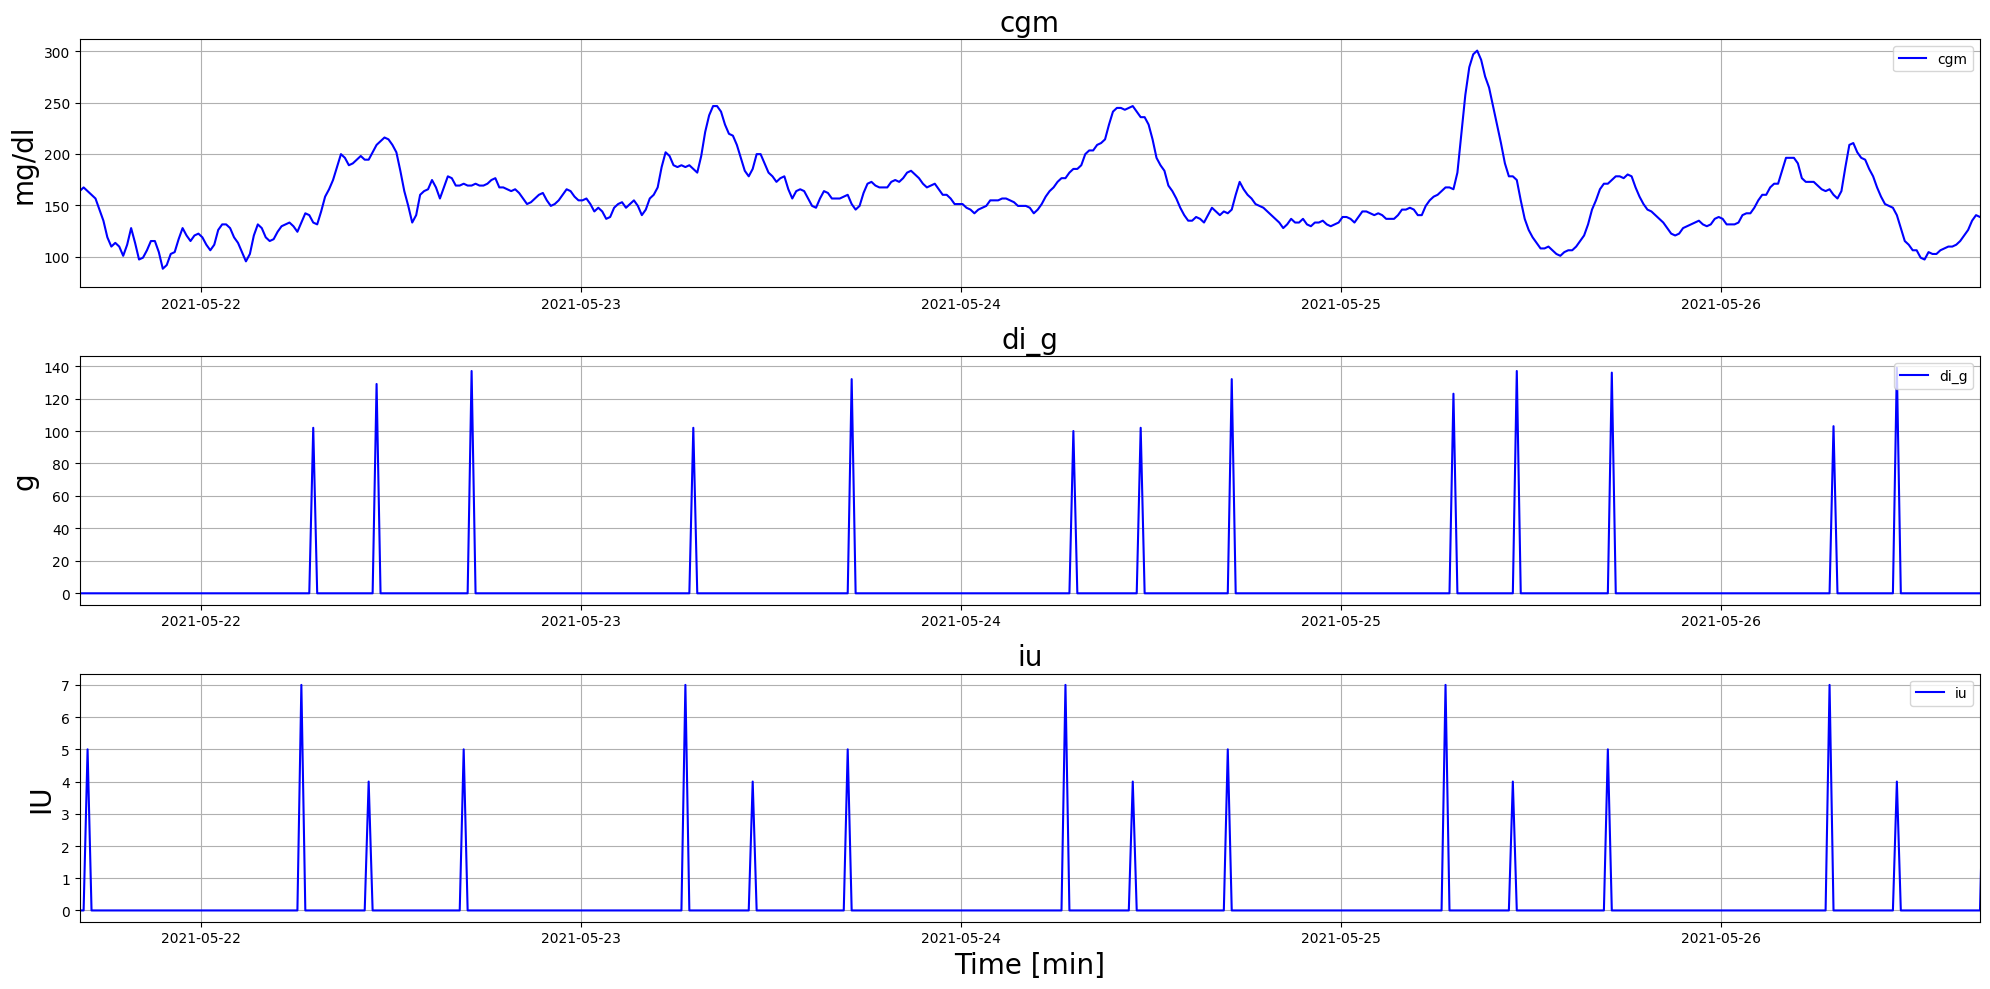

In [9]:
print(f"Data for subject {data[subject_idx]['id']}")

etsa.plot_ts(domain = 'time',
             xlim = [data[subject_idx]['date'].min(),
                     data[subject_idx]['date'].min() + timedelta(days = 5)],
             figsize = (20, 10),
             fig_num = 1)


We observe that most of the CGM values are quasi-continuous, or high-frequency discrete, ranging between 100 and 300 mg/dl, fluctuating about the 150 mg/dl level, and exhibiting occasional transient rises. Dietary intake and insulin doses are episodic, or low-frequency discrete. As anticipated, these transient rises in CGM appear to correlate in time with meals, which in turn correlate with the timing of insulin doses.

We may better visualize this relationship by plotting the cross-correlation between each signal in the time or frequency domains. For greater clarity, very slow trends and the mean value are removed by subtracting the 6-day (576 sample) Hanning-windowed moving average in the CGM signal before computing the cross-correlation functions. Let's explore the data in the frequency domain by displaying the cross power spectral density (Fourier transform of the cross-correlation function):

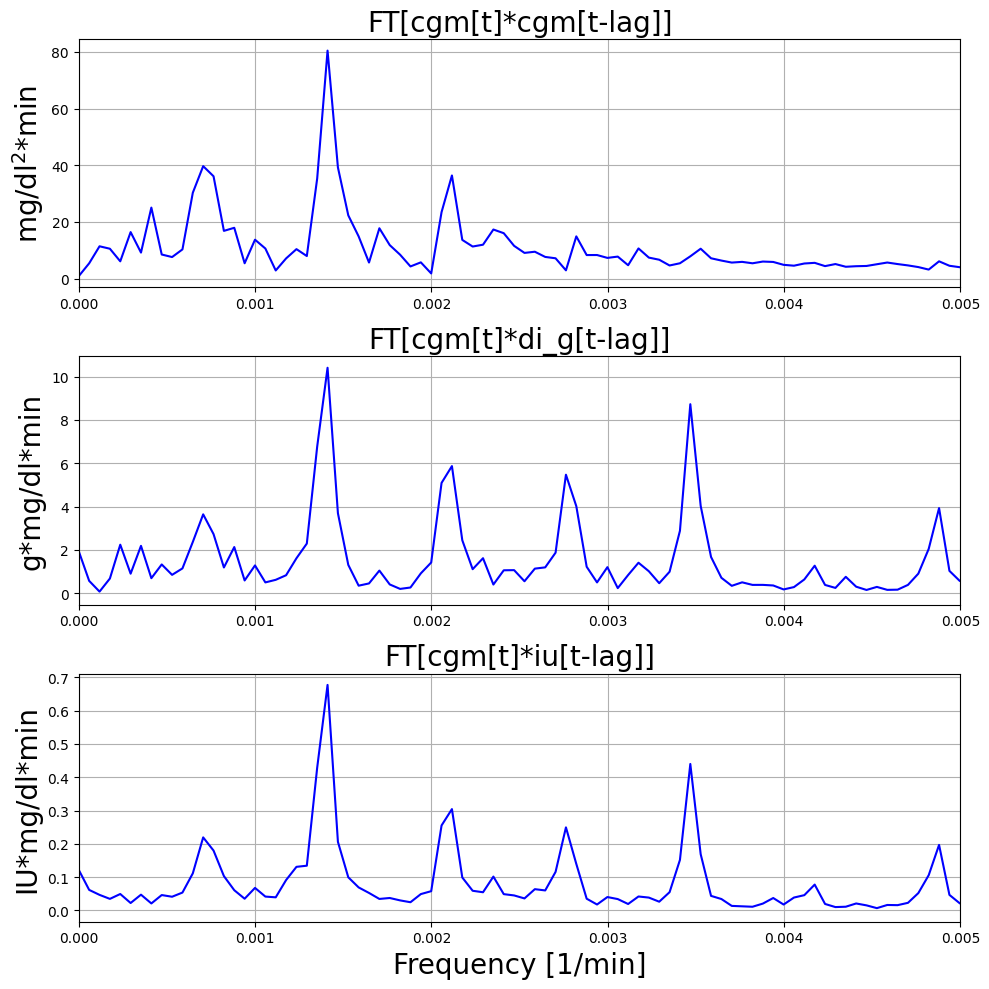

In [10]:
etsa.generate_xcorr(hann_window_len = [24*4*6, None, None])

etsa.plot_xcorr(fig_num = 2,
                data_names = ['cgm'],
                domain = 'frequency',
                xlim = [0, 0.005],
                figsize = (10, 10))

For this person, most of the variability in CGM resides below 0.003 cycles/min, or 6 hours. There is a clear peak at around 0.0014 cycles/min in all three signals corresponding to the 8 hour cycle, due to the timing of meals from day to day. In addition, we observe another strong peak around 0.0034 cycle/min in both DIg and I, due to this individual having multiple meals with corresponding insulin within a single day.

Upon a cursory review of the data, you'll see that the temporal/spectral characteristics are similar from person to person, with occasional rises in CGM levels corresponding to meals and inslusin treatments associated. Since we aim to predict CGM from historical CGM, DI, and I, we need a cohort that contains available data for all three avariables in each person in the cohort. Let's filter the larger 125-subject dataset for these criteria:

In [11]:
sub_cohort = []
for i in range(len(data)):
  if ((data[i]['di_g'] > 0).sum()/(data[i]['date'].max() - data[i]['date'].min()).days >= 2) and \
     ((data[i]['iu'] > 0).sum()/(data[i]['date'].max() - data[i]['date'].min()).days >= 2) and \
     (data[i]['date'].max() - data[i]['date'].min()).days >= 3:
    sub_cohort.append(data[i])

print(f"{len(sub_cohort)} subjects in sub-cohort.")

26 subjects in sub-cohort.


<a id="signal-preprocessing"></a>
## Signal Preprocessing

Our EDA revealed the temporal characteristics of the time series data from a single subject. You may toggle through the data from other subjects to provie a basis to prepare the data for training. This section will prepare the data for training using our `TimeSeriesDatamodule` class. This class wraps the `LightningDataModule` class provided by PyTorch Lightning, which itself is a useful wrapper that manages data loading, preprocessig, and splitting. Let's instiatate our class with the desired settings:

In [12]:
t = torch.arange(len(sub_cohort[0]['date'])).reshape(-1, 1)

sub_cohort[0]['z'] = torch.sin(2*torch.pi*t*.05)

In [29]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

datamodule = TimeSeriesDataModule(data = sub_cohort,
                                  time_name = 'date',
                                  input_names = ['cgm', 'di_g', 'iu'],
                                  output_names = ['cgm'],
                                  step_shifts = {'di_g': 1, 'iu': 1},
                                  combine_inputs = [['cgm', 'di_g', 'iu']],
                                  dt = timedelta(minutes = 15),
                                  time_unit = 'M',
                                  transforms = {'all': FeatureTransform('minmax', minmax = [0, 1])},
                                  pct_test_val = [.2, .2],
                                  input_len = [24], output_len = [6],
                                  shift = [6], stride = 6,
                                  batch_size = 32,
                                  shuffle_train = True,
                                  # pad_data = True,
                                  print_summary = True,
                                  device = device, dtype = torch.float32)

This instance is configured with the sub cohort (N = 26) with CGM, DI, and I available for each subject. Each subject has a dictionary containing their time series data. Each dictionary has a time variable, `date`, with corresponding inputs `cgm`, `di_g`, and `iu`. To account for the physiological transit time between the ingestion of a meal or administration of an insulin dose, we shift these two signals one sample to the right (15 minute delay). Since all data is non-negative, we normalize the data between 0 and 1 using our `FeatureTransform` class.

After normalization, all three inputs are combined into to one signal with three features. Of the total 26 subjects, 20 (80%) are initially taken for training and the remaining 6 are used for testing. Of the 20 in the initial training set, 4 (20%) are used for validation, resulting in 16 total subjects in the final training set. We consider the prediction of 6 future steps (1.5 hours) given 24 steps (6 hours) of historical data.

The indices corresponding to the output in the sample window are shifted 5 steps to the right, aligning the output's start with the input's end. We use a stride of 6 to ensure that each sample is non-overlapping, providing a unique prediction for each sample.

The batch size is set to 256 samples.

We specify that all the samples between the 16 subjects in the training set be randomized from batch to batch to improve subject-level generalization.

We use a GPU (device = `cuda`) if one is available.

To prepare (define input-output variables and apply the transformations) and setup (split into training, validation, and testing sets) the data, we can run the `prepare_data` and `setup` methods:

In [30]:
datamodule.prepare_data()
datamodule.setup(stage = 'fit')

print(f"{len(datamodule.train_data)} subjects in training set")
print(f"{len(datamodule.val_data)} subjects in validation set")
print(f"{len(datamodule.test_data)} subjects in test set")

16 subjects in training set
4 subjects in validation set
6 subjects in test set


Let's plot the input-output data from three of subjects in the training set:

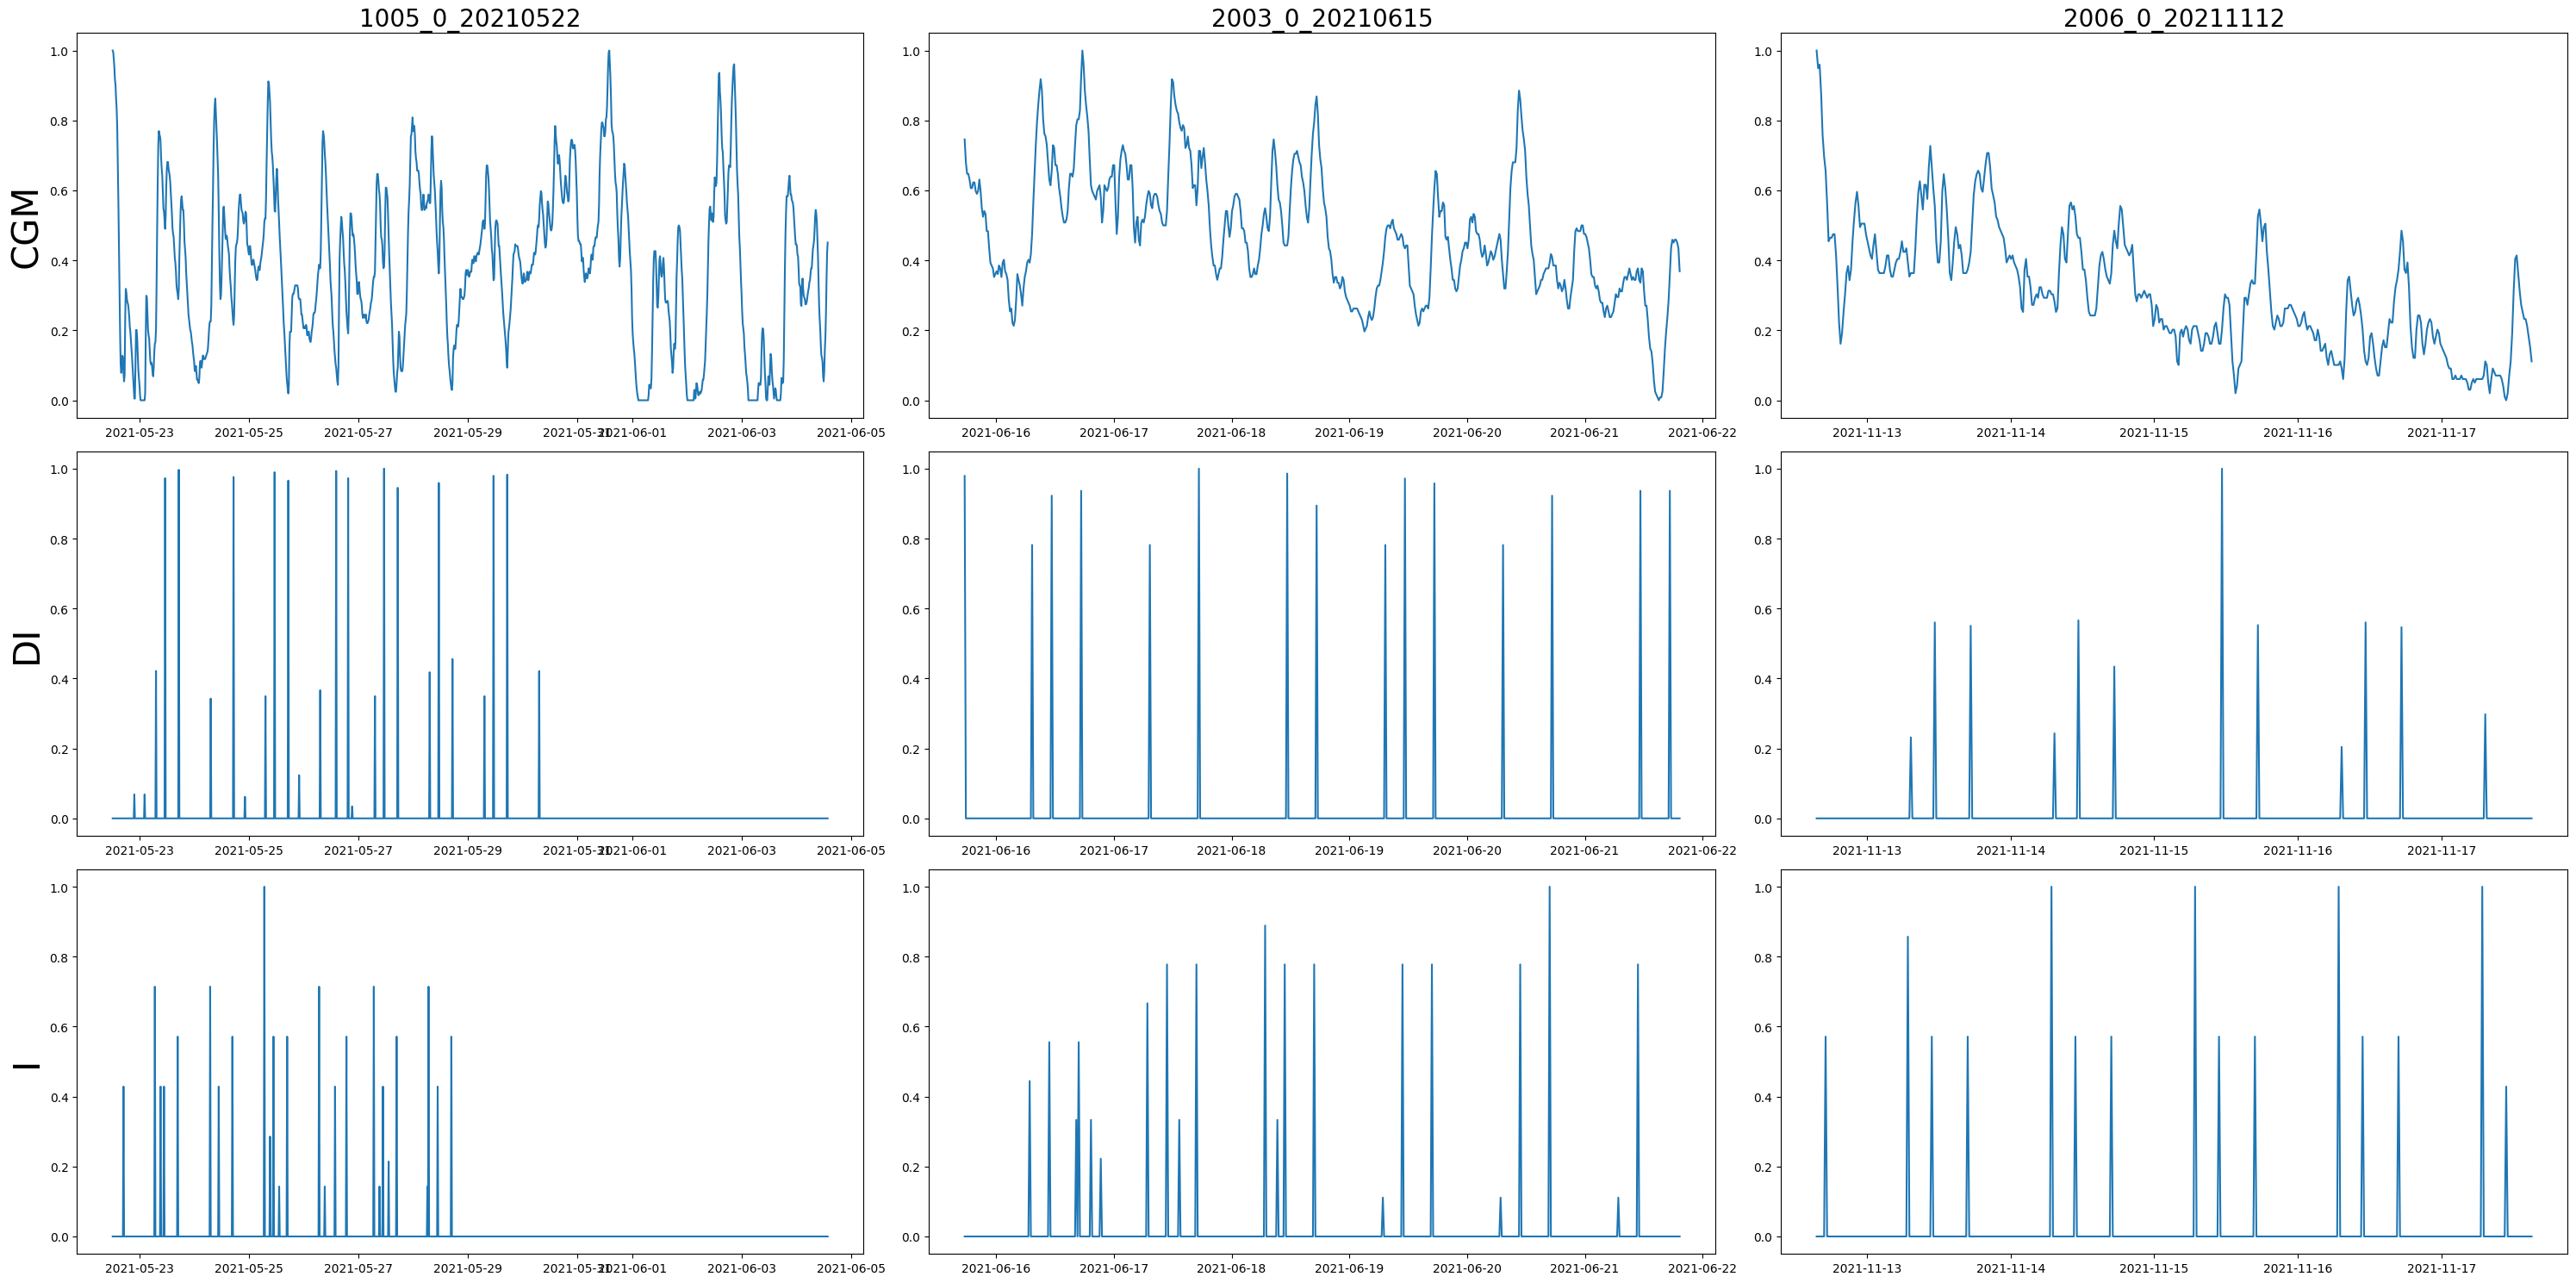

In [31]:
fig, ax = plt.subplots(3, 3, figsize = (30, 15))

for j,i in enumerate([random.randint(0, len(datamodule.train_data)) for _ in range(3)]):
  ax[0, j].plot(datamodule.train_data[i]['date'], datamodule.train_data[i]['cgm'].cpu())
  ax[1, j].plot(datamodule.train_data[i]['date'], datamodule.train_data[i]['di_g'].cpu())
  ax[2, j].plot(datamodule.train_data[i]['date'], datamodule.train_data[i]['iu'].cpu())

  ax[0,j].set_title(datamodule.train_data[i]['id'], fontsize = 20)

  if j == 0:
    ax[0,0].set_ylabel('CGM', fontsize = 30)
    ax[1,0].set_ylabel('DI', fontsize = 30)
    ax[2,0].set_ylabel('I', fontsize = 30)

fig.tight_layout()

We see that the data is properly normalized between 0 and 1.

Our `datamodule` object is also used to build the training, validation, and testing dataloaders, which generates their respective batches. Let's visualize the training batches by runing the `train_dataloader` method (native to pl.LightningDataModule) to create the training dataloader. Since we set `shuffle_train = True` in our initial instantiation, we need to set it to `False` temporarily to generate the training dataloader so that the samples are back in the original order:

In [32]:
datamodule.shuffle_train = False
datamodule.train_dataloader()
datamodule.shuffle_train = True

Data length: 356
Window size: 30
Step indices: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]
Input indices for X1: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23]
Output indices for cgm: [24, 25, 26, 27, 28, 29]
Data length: 932
Window size: 30
Step indices: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]
Input indices for X1: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23]
Output indices for cgm: [24, 25, 26, 27, 28, 29]
Data length: 1255
Window size: 30
Step indices: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]
Input indices for X1: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23]
Output indices for cgm: [24, 25, 26, 27, 28, 29]
Data length: 765
Window size: 30
Step indices: [0, 

Since `print_summary = True`, we get a summary of the dataset for each subject in the training set. We see that a single sample is 30 steps long. The input indices for the CGM data are [0, 1, 2, ..., 23], which correspond to the first 24 data points in each window. The input indices for for DI-I data ("X1") are [1, 2, 3, ..., 24], indicating that it starts from the second data point and includes 24 consecutive data points. The output indices for the CGM data are [24, 25, 26, 27, 28, 29], representing the last 6 data points in the window (the prediction horizon), which are the data points to be predicted.

Now, let's collect the training samples.

In [33]:

# train
train_input, train_target, train_steps = [], [], []
for batch in datamodule.train_dl.dl:
  train_input.append(batch[0][:batch[3]])
  train_target.append(batch[1][:batch[3]])
  train_steps.append(batch[2][:batch[3]])

train_input = torch.cat(train_input,0)
train_target = torch.cat(train_target,0)
train_steps = torch.cat(train_steps,0)

train_input_window_idx = datamodule.train_input_window_idx
train_output_window_idx = datamodule.train_output_window_idx

train_output_mask = datamodule.train_output_mask
#

input_output_idx = datamodule.input_output_idx
output_input_idx = datamodule.output_input_idx

print(f"Input batch shape: {list(train_input.shape)}")
print(f"Label batch shape: {list(train_target.shape)}")
print(f"Steps batch shape: {list(train_steps.shape)}")

Input batch shape: [1786, 24, 3]
Label batch shape: [1786, 6, 1]
Steps batch shape: [1786, 30]


We see that there are 1786 total samples (~112 samples per subject) across all of the batches the training set.

Let's plot three consecutive samples:

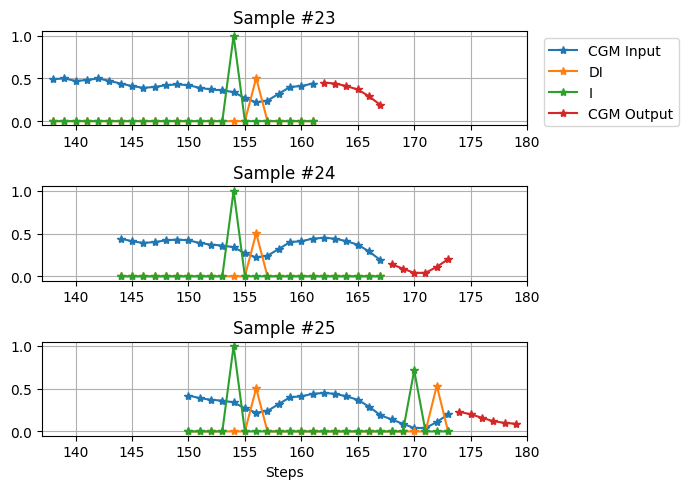

In [34]:
sample_idx = [23, 24, 25]

fig, ax = plt.subplots(len(sample_idx), 1, figsize = (7, 5))

min_step, max_step = train_steps[sample_idx].cpu().min()-1, train_steps[sample_idx].cpu().max()+1

for j,i in enumerate(sample_idx):
  ax_j = ax[j] if len(sample_idx) > 1 else ax

  ax_j.plot(train_steps[i][train_input_window_idx[0]].cpu(),
             train_input[i][train_input_window_idx[0], 0].cpu(), '-*' , label = 'CGM Input')
  ax_j.plot(train_steps[i][train_input_window_idx[0]].cpu(),
            train_input[i][train_input_window_idx[0], 1].cpu(), '-*' , label = 'DI')
  ax_j.plot(train_steps[i][train_input_window_idx[0]].cpu(),
            train_input[i][train_input_window_idx[0], 2].cpu(), '-*' , label = 'I')

  ax_j.plot(train_steps[i][train_output_window_idx[0]].cpu(),
            train_target[i].cpu(), '-*', label = 'CGM Output')

  ax_j.set_xlim(min_step, max_step)

  if j == 0:
    ax_j.legend()
    ax_j.legend(loc = 'upper left', bbox_to_anchor = (1.02, 1), ncol = 1)
  if j == len(sample_idx) - 1: ax_j.set_xlabel('Steps') ;
  ax_j.set_title(f"Sample #{i}") ;

  ax_j.grid()

fig.tight_layout()


We see that the consecutive samples include non overlapping predictions of CGM given history of CGM, dietary intake, and insulin doses.

<a id="model-selection"></a>
## Model Selection

The most useful aspect of the [TorchTimeSeries](https://github.com/bchenley/TorchTimeSeries/tree/main) package is the facilitation of model architecture selection. The primary intent of this package was to provide a general and flexible way to develop models based on neural networks frequently used in time series modeling today. It's still a work in progress, but I'd like to share how it works. The general architecture of the model consists of five possible layers, as shown in the diagram below.





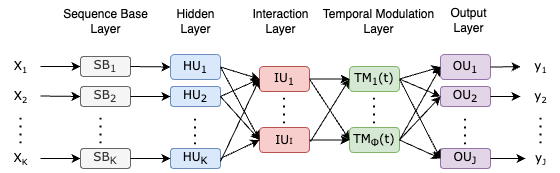

In [35]:
image_path = '/content/TorchTimeSeries/models/SequenceModel.drawio.png'
image = Image.open(image_path)
image

The model is generally a multi-input-multi-output configuration with 5 possible layers.

The first layer is the **sequence base layer**, which serves as a filterbank capturing the dynamics of the input-output relation. Each input `X_k` has its own individual "base", which for now can be a Gated Recurrent Unit (GRU), Long-Short-Term Memory (LSTM) network, Laguerre Recurrent Unit (LRU), a transformer encoder/decoder, or a convolutional net (CNN).

The second layer is the **input-associated hidden layer**, in which the kth hidden unit (`HU_k`) receives the output of the sequence base layer corresponding to the kth input. This layer is static (independent of time) and is made up of a linear transformation followed by a nonlinear activation defined by the user. Therefore, this layer models the dynamic nonlinearity of the input-output transformation. The activation functions in this layer include commonly used functions such as ReLU, sigmoid, softmax, and tanh. Additionally, a polynomial activation is provided as an alternative nonlinear activation to offer more flexibility.

The third layer is the **interaction layer**, facilitating "cross-talk" between the inputs as they affect the outputs. Unlike the input-associated hidden layer, this layer is fully connected, so that the ith interaction unit (`IU_i`) receives the output of all input-associated hidden units. It provides the same flexibility in the choice of nonlinear activation functions.

The fourth layer is the **temporal modulation layer**, responsible for modeling nonstationary behavior. This layer does not directly model the time-varying characteristics of the input or output, but rather the time dependent relation between the inputs and outputs. Currently, this layer includes options such as Legendre polynomials, Chebychev polynomials, Fourier basis functions, and the sigmoid function. However, additional functions (such as Hermite and Laguerre) can be added by the user.

Finally, the fifth layer is the **output layer**, which generates the model's outputs.

It's important to note that this is the full architecture. However, you can specify a model with fewer layers based on your needs. In this notebook, we will focus only on the sequence base, hidden layer, and output layer to build two models. One will have a simple architecture, and the other will be more complex.



Let's construct our first model with a simple architecture. Our model is a single-input-single-output model where the input has three features. We use 24 previous steps of the data to predict the next 6 steps of CGM. We select an LSTM model as our base to extract a temporal respresentation of the input data useful for generating the 6-step joint prediction. We then send the output of the LSTM to a fully connected hidden layer with a ReLU activation. The output of this layer is sent to a linear output to generate 6 features that are flattened along the time dimension to represent the 6-step forecast.

In [78]:
model_1 = SequenceModel(num_inputs = 1, num_outputs = 1,
                        input_size = [3], input_len = [24],
                        output_size = [1], output_len = [6],
                        # Sequence base layer
                        base_type = ['lstm'],
                        base_hidden_size = [128],
                        base_use_last_step = [True],
                        base_num_layers = [2],
                        base_rnn_dropout_p = [0.2],
                        # Hidden layer
                        hidden_out_features = [64], hidden_bias = [False],
                        hidden_activation = ['relu'],
                        hidden_dropout_p = [0.2],
                        # Output layer
                        output_flatten = ['feature'],
                        device = device, dtype = torch.float32)

model_1

seq_base.0.base.weight_ih_l0: shape = torch.Size([512, 3]). 1536 parameters. Trainable
seq_base.0.base.weight_hh_l0: shape = torch.Size([512, 128]). 65536 parameters. Trainable
seq_base.0.base.bias_ih_l0: shape = torch.Size([512]). 512 parameters. Trainable
seq_base.0.base.bias_hh_l0: shape = torch.Size([512]). 512 parameters. Trainable
seq_base.0.base.weight_ih_l1: shape = torch.Size([512, 128]). 65536 parameters. Trainable
seq_base.0.base.weight_hh_l1: shape = torch.Size([512, 128]). 65536 parameters. Trainable
seq_base.0.base.bias_ih_l1: shape = torch.Size([512]). 512 parameters. Trainable
seq_base.0.base.bias_hh_l1: shape = torch.Size([512]). 512 parameters. Trainable
hidden_layer.0.F.0.weight: shape = torch.Size([64, 128]). 8192 parameters. Trainable
output_layer.0.F.0.weight: shape = torch.Size([6, 64]). 384 parameters. Trainable
output_layer.0.F.0.bias: shape = torch.Size([6]). 6 parameters. Trainable
-------------------------------------
208774 total parameters.
208774 total tr

Setting `base_use_last_step = True` specifies that only the last (24th) step of the LSTM output is sent to the next layer for processing. The next layer is linear (non-affine) transformation that reduces the latent space from 128 to 64 and applies a ReLU activation. Finally, the output layer applies an affine transformation to generate the 6-step prediction. We apply dropout to the LSTM and hidden layers to mitigate overfitting.

Let's confirm the model generates an ouptut with desired shape, given an appropriately shaped input:

In [79]:
batch_size = 256
X = torch.randn((batch_size, 24, 3)).to(device = device, dtype = torch.float32) # [dummy batch size, input_len, input_size]

print(f"Output shape of model_1: {model_1(X)[0].shape}")

Output shape of model_1: torch.Size([256, 6, 1])


We observe that the model output is [256, 6, 1], as desired.

<a id="training-and-evaluation"></a>
## Model Training and Evaluation

To train our model, we emply our `SequenceModule` class, which wraps the pl.LightningModule class and manages training, evaluation, testing, and prediction. There are three required attibutes: the model, the criterion, and the optimizer. Our model, `model_1`, as already been defined. The criterion is the objective function we use to train our model. We define the objective fnction using our `Criterion` class, which may be used to instantiate a variety of loss or metric functions. The optimizer is defined using Pytorch's built-in optimizer library:


In [80]:
# lightingmodule
loss_fn = Criterion('rmse', dims = (0, 1))
metric_fn = Criterion('r2', dims = (0, 1))

opt = torch.optim.Adam(params = model_1.parameters(),
                       betas = [0.9, 0.999],
                       lr = 0.002)

module_1 = SequenceModule(model = model_1,
                          opt = opt, loss_fn = loss_fn, metric_fn = metric_fn,
                          stateful = False,
                          teach = True,
                          track_performance = True,
                          track_params = True)
#

Here, we have set our loss to be the root mean square error (RMSE) and our metric the coefficient of determination (R-squared). A metric is not necessary, but can be useful in providing a more interpretable measure of model accuracy. The RMSE is useful in penalizing larger errors while keeping the units equal to the target variable. R-squared measues the amount of the target variable that our model explains and helps us understand the model's goodness of fit compared to a simple horizontal line. Since our output target and prediction will always have the shape [batch_size, length, num_output_features], we specify that the loss average over the first two dimension. Using PyTorch's built-in optimizer library, the optimizer is set to the commonly used Adam. We now have enough to instatiate our lightning module. However, we'd also like to track the performance of the model to plot the results later (`track_performance = True`), as well as the learning curves of the model paramters (`track_params = True`).

To fit the model, we call `fit`, which in turn instantiates Lightning's `Trainer` class to handle the training, validation, and prediction loops.

Let's fit our first model to the data from the 16 subjects in the training set using a callback that stops the training early if the validation error does not improve after 50 consecutive epochs.

In [81]:
callbacks = [pl.callbacks.EarlyStopping(monitor = 'val_epoch_loss',
                                        patience = 50,
                                        verbose = False,
                                        min_delta = 0,
                                        mode = 'min')]

datamodule.print_summary = False

module_1.fit(datamodule = datamodule,
             max_epochs = 500,
             callbacks = callbacks)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name  | Type          | Params
----------------------------------------
0 | model | SequenceModel | 208 K 
----------------------------------------
208 K     Trainable params
0         Non-trainable params
208 K     Total params
0.835     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:442: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Validation Dataloader Created.
Training Dataloader Created.


/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:442: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

The number of epochs completed will vary from session to session, but the early stopping callback should interrupt training between 100-200 epochs.

<a id="results"></a>
## Results

With our model trained, we must now examine its performance. All of the tools for this task are in `SequenceModule`. The first function we will use is `plot_history`, which allows us to plot the learning curves of loss/metric criterion during training and validation and the parameters during training. Let's look at the training and validation loss:

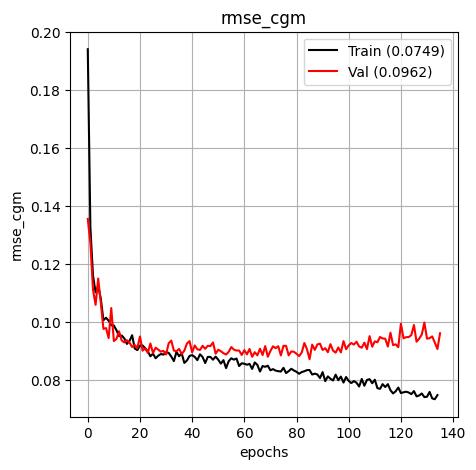

In [82]:
module_1.plot_history(['rmse_cgm'])

Results will vary between different training session, however you should observe a decrease in the training and validation MSE over the epochs. Early stopping should help prevent overfitting, but if you observe that the validation loss begins to increase too much as the training error decreaes, please try reducing the patience of the callback, decreasing the number of features in the LSTM or hidden layer, or increasing the dropout probabilities.

Let's also plot R-squared:

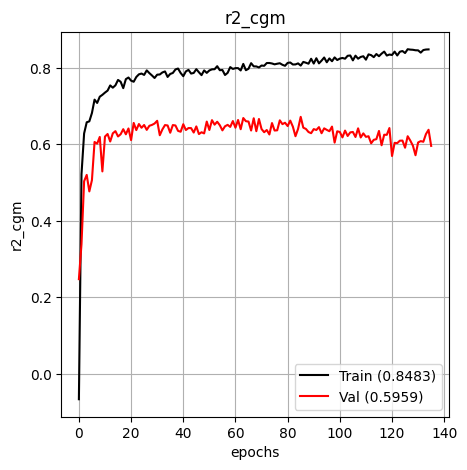

In [83]:
module_1.plot_history(['r2_cgm'])

As desired, R-squred approaches one in our training set. However, our model performed slightly worse on the validation data (averged over 6 subjects).

We may also visualize the model parameters to inspect if they've converged:

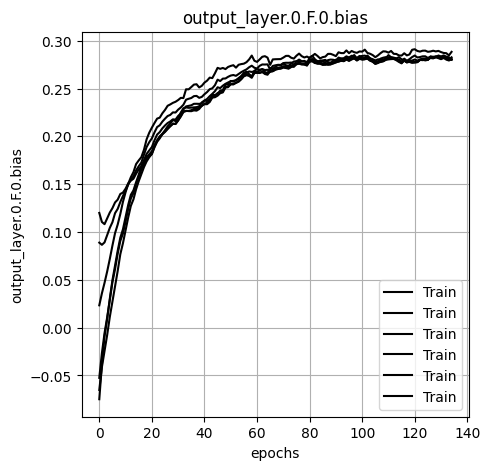

In [84]:
module_1.plot_history(['output_layer.0.F.0.bias'])

We next call the `predict` method to generate model predictions for all 26 subjects.

In [88]:
module_1.predict()

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Training Dataloader Created.


/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:442: PossibleUserWarning: The dataloader, predict_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Predicting: 0it [00:00, ?it/s]

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:442: PossibleUserWarning: The dataloader, predict_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Predicting: 0it [00:00, ?it/s]

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:442: PossibleUserWarning: The dataloader, predict_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Predicting: 0it [00:00, ?it/s]

To plot the results for a single person, we use the `plot_predictions` function. Let's first create a list of the IDs in the three datasets.

In [89]:
train_ids = [data_['id'] for data_ in module_1.trainer.datamodule.train_data]
val_ids = [data_['id'] for data_ in module_1.trainer.datamodule.val_data]
test_ids = [data_['id'] for data_ in module_1.trainer.datamodule.test_data]

print(f"Train Subjects: {train_ids}")
print(f"Validation Subjects: {val_ids}")
print(f"Test Subjects: {test_ids}")

Train Subjects: ['1002_2_20210909', '1002_1_20210521', '1005_0_20210522', '1008_0_20210713', '1002_0_20210504', '2002_0_20210513', '2005_0_20211201', '2003_0_20210615', '2009_0_20211103', '2008_0_20220118', '2006_0_20211112', '2013_0_20220123', '2019_0_20210513', '2023_0_20210812', '2025_0_20210506', '2027_0_20210521']
Validation Subjects: ['2039_0_20210615', '2034_0_20210624', '2036_0_20210803', '2038_0_20210608']
Test Subjects: ['2031_0_20210601', '2033_0_20210615', '2041_0_20210813', '2043_0_20210513', '2042_0_20211019', '2044_0_20211101']


You may select any person you like. Let's look at the first person in the test set:

In [90]:
id = '2031_0_20210601'

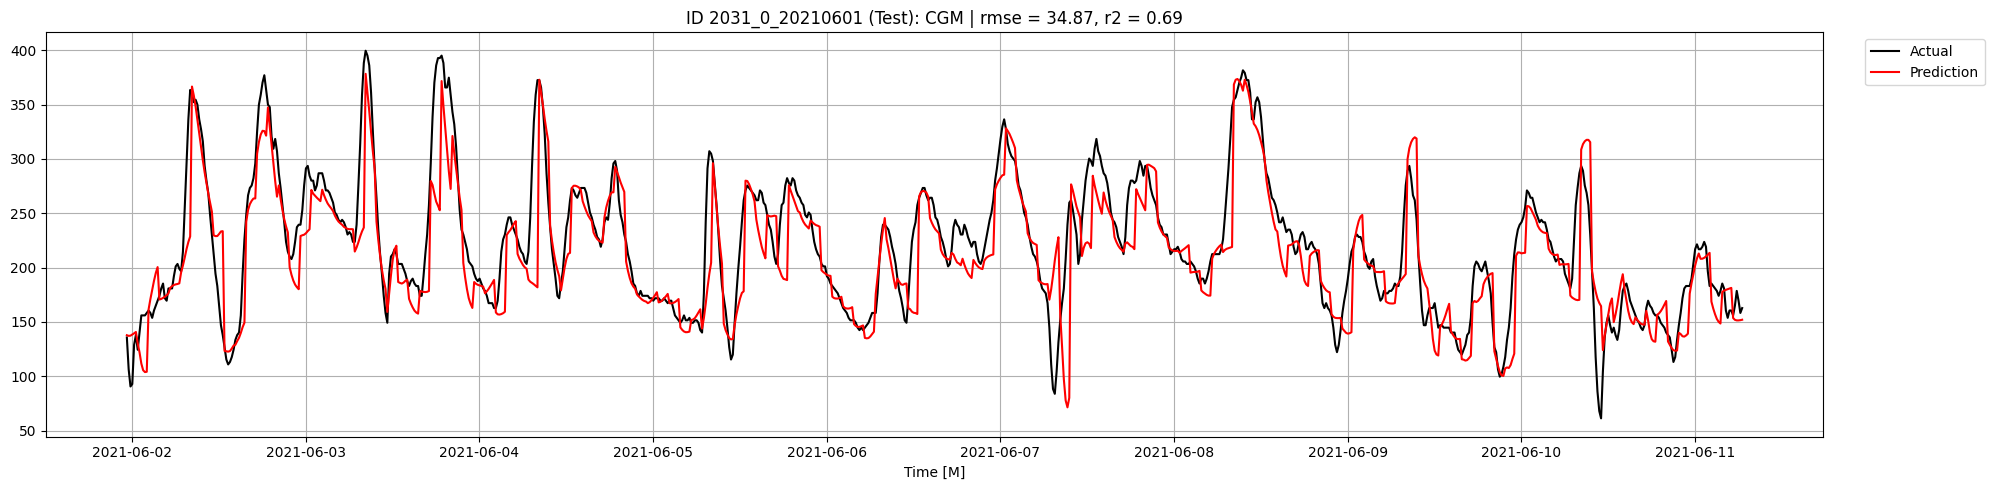

In [91]:
module_1.plot_predictions(id = id)

If you are interested in visualizing the prediction error, run `plot_residuals` to plot the residuals over time and in a histogram:

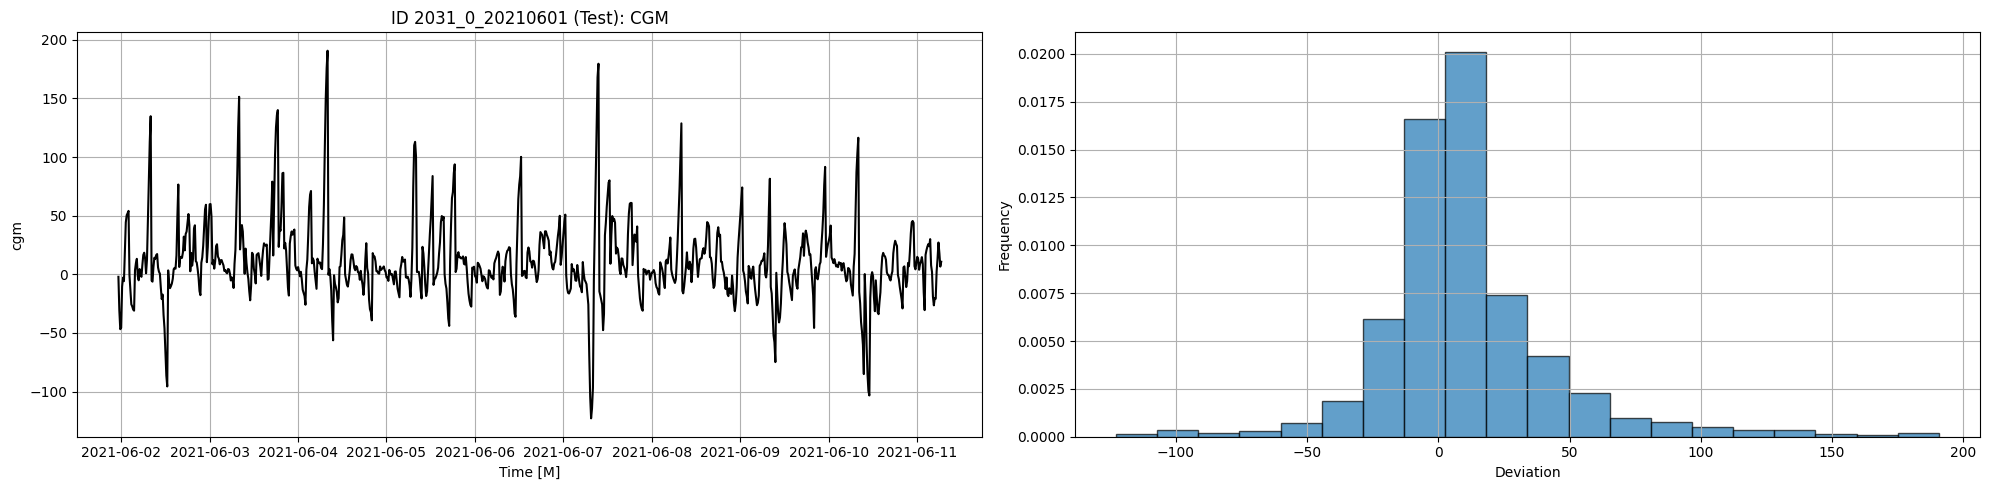

In [93]:
module_1.plot_residuals(id = id)

Our primary aim is to generate a 1.5 hour forecast for CGM. To do this, we run `forecast`, with the desired number of prediciton steps set by `num_forecast_steps`:

In [94]:
module_1.forecast(id = id,
                  num_forecast_steps = 6) # id = id)

The `plot_forecast` function plots the forecast with a few points of the past values of the output (set by `window_len`) to provide historical context.

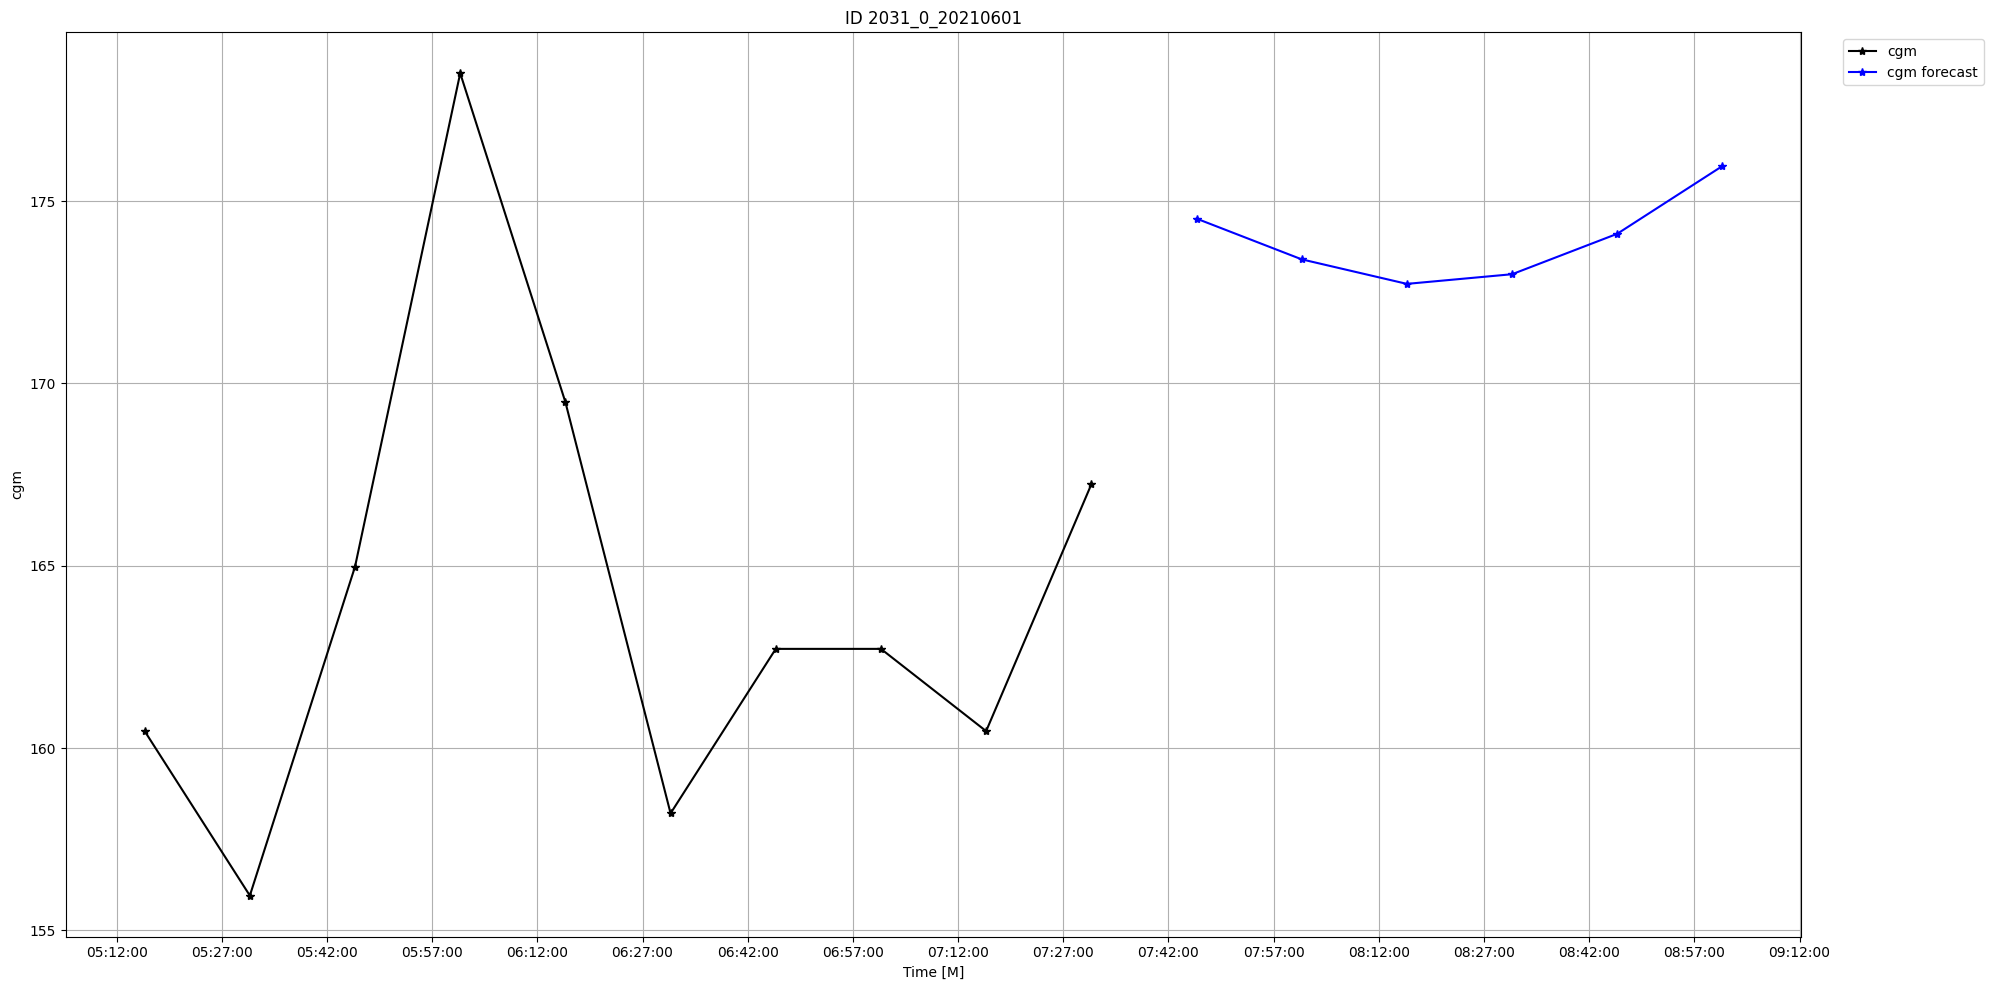

In [95]:
module_1.plot_forecast(figsize = (20, 10),
                       window_len = 10)

This is the result week seek. Of course, the result above is for a single, relatively simple model.

Let's use our tool to build a more complex model. The architecture will be based on a model from a recently published [paper](https://journals.sagepub.com/doi/full/10.1177/19322968221092785#bibr34-19322968221092785) that implements a convolutional neural network (CNN) in cascade with an LSTM. We can build this CNN-LSTM model our `Seq2SeqModel`, which combines two `SequenceModel` modules, one that is based on a CNN and other based on an LSTM. Our version is slightly simpler than the paper's, but complex enough for illustration:

In [131]:
cnn_lstm_encoder = SequenceModel(num_inputs = 1, num_outputs = 1,
                                 input_size = [3], input_len = [24],
                                 output_size = [0], output_len = [24],
                                 base_seq_type = ['encoder'],
                                 base_type = ['cnn'],
                                 base_cnn_out_channels = [[32, 64]],
                                 base_cnn_kernel_size = [[(5,), (20,)]],
                                 base_cnn_dropout_p = [[0.2, 0.2]],
                                 base_hidden_size = [64],
                                 output_flatten = ['time'],
                                 device = device, dtype = torch.float32)

cnn_lstm_decoder = SequenceModel(num_inputs = 1, num_outputs = 1,
                                 input_size = [cnn_lstm_encoder.total_output_size], input_len = [cnn_lstm_encoder.max_output_len],
                                 output_size = [1], output_len = [6],
                                 base_seq_type = ['decoder'],
                                 base_type = ['lstm'],
                                 base_num_layers = [2],
                                 base_hidden_size = [128],
                                 base_rnn_dropout_p = [0.2],
                                 base_use_last_step = [True],
                                 hidden_out_features = [64], hidden_bias = [False],
                                 hidden_activation = ['relu'],
                                 hidden_dropout_p = [0.2],
                                 output_flatten = ['feature'],
                                 device = device, dtype = torch.float32)

model_2 = Seq2SeqModel(cnn_lstm_encoder, cnn_lstm_decoder,
                       enc_out_as_dec_in = True,
                       device = device, dtype = torch.float32)

model_2

Seq2SeqModel(
  (encoder): seq_base.0.base.cnn.0.0.weight: shape = torch.Size([32, 3, 5]). 480 parameters. Trainable
  seq_base.0.base.cnn.0.0.bias: shape = torch.Size([32]). 32 parameters. Trainable
  seq_base.0.base.cnn.1.0.weight: shape = torch.Size([64, 32, 20]). 40960 parameters. Trainable
  seq_base.0.base.cnn.1.0.bias: shape = torch.Size([64]). 64 parameters. Trainable
  -------------------------------------
  41536 total parameters.
  41536 total trainable parameters.
  (decoder): seq_base.0.base.weight_ih_l0: shape = torch.Size([512, 1]). 512 parameters. Trainable
  seq_base.0.base.weight_hh_l0: shape = torch.Size([512, 128]). 65536 parameters. Trainable
  seq_base.0.base.bias_ih_l0: shape = torch.Size([512]). 512 parameters. Trainable
  seq_base.0.base.bias_hh_l0: shape = torch.Size([512]). 512 parameters. Trainable
  seq_base.0.base.weight_ih_l1: shape = torch.Size([512, 128]). 65536 parameters. Trainable
  seq_base.0.base.weight_hh_l1: shape = torch.Size([512, 128]). 65536 

We have instatiated two modules to handle the processing of the CNN and LSTM. The CNN-based module serves as the "encoder", processing the historical CGM, dietary intak, and insulin doses using two CNN layers. The first layer has kernel size of 5 with 32 feature maps, capturing local dynamic information, while the second layer has a kernel size of 20 with 64 feature maps, capturing more global dynamics. With an initial sequence length of 24, the length of the output of the second layer exactly 1, resulting in a 64-long vector that is flattend along the time dimension to be processed by the LSTM.

Our LSTM in this model serves as the "decoder", processing the output of the CNN module. The last step of the LSTM output is transformed by the decoders hidden layer before being sent to the output layer to generate our 6-step forecast, similar to the first model.

Let's also confirm that our second model generates the correct shaped output.



In [132]:
print(f"Output shape of model_2: {model_2(X)[0].shape}")

Output shape of model_2: torch.Size([256, 6, 1])


Now, let's train our model as before. Only the model performance is tracked for this larger model to avoid running out of memory.

In [133]:
# lightingmodule
loss_fn = Criterion('rmse', dims = (0, 1))
metric_fn = Criterion('r2', dims = (0, 1))

opt = torch.optim.Adam(params = model_2.parameters(),
                       betas = [0.9, 0.999],
                       lr = 0.002)

module_2 = SequenceModule(model = model_2,
                          opt = opt, loss_fn = loss_fn, metric_fn = metric_fn,
                          track_performance = True,
                          track_params = False)
#

In [134]:
callbacks = [pl.callbacks.EarlyStopping(monitor = 'val_epoch_loss',
                                        patience = 50,
                                        verbose = False,
                                        min_delta = 0,
                                        mode = 'min')]

module_2.fit(datamodule = datamodule,
             max_epochs = 500,
             callbacks = callbacks)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name  | Type         | Params
---------------------------------------
0 | model | Seq2SeqModel | 249 K 
---------------------------------------
249 K     Trainable params
0         Non-trainable params
249 K     Total params
0.997     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:442: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Validation Dataloader Created.
Training Dataloader Created.


/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:442: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

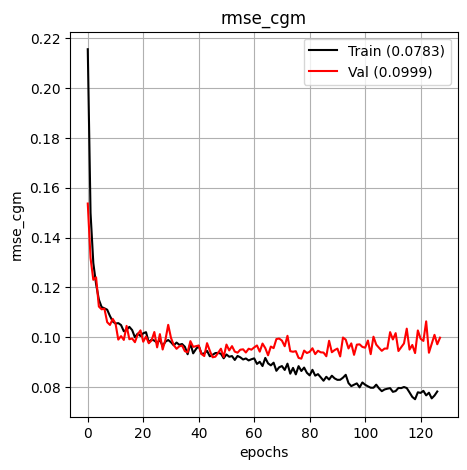

In [135]:
module_2.plot_history(['rmse_cgm'])

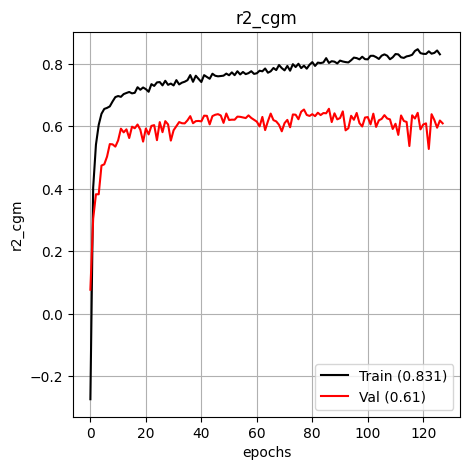

In [136]:
module_2.plot_history(['r2_cgm'])

In [137]:
module_2.predict()

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Training Dataloader Created.


/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:442: PossibleUserWarning: The dataloader, predict_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Predicting: 0it [00:00, ?it/s]

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:442: PossibleUserWarning: The dataloader, predict_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Predicting: 0it [00:00, ?it/s]

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:442: PossibleUserWarning: The dataloader, predict_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Predicting: 0it [00:00, ?it/s]

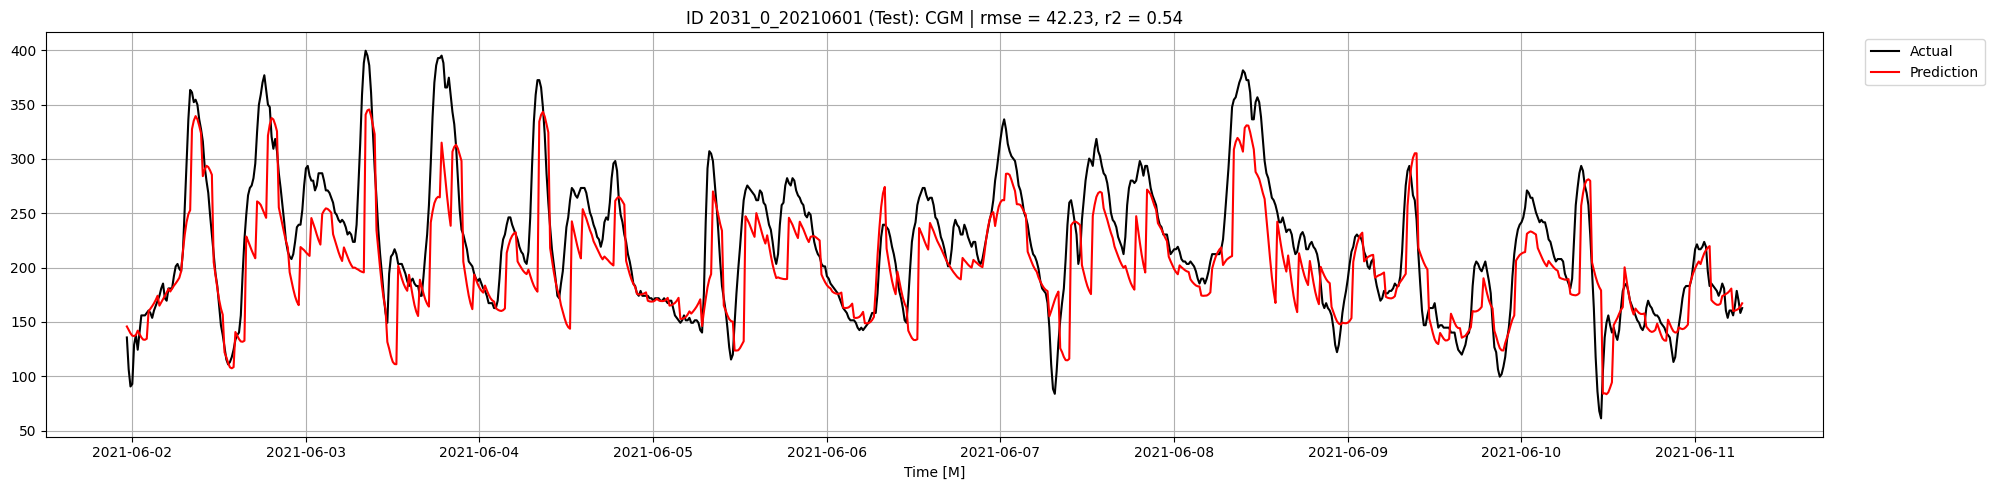

In [138]:
module_2.plot_predictions(id = id)

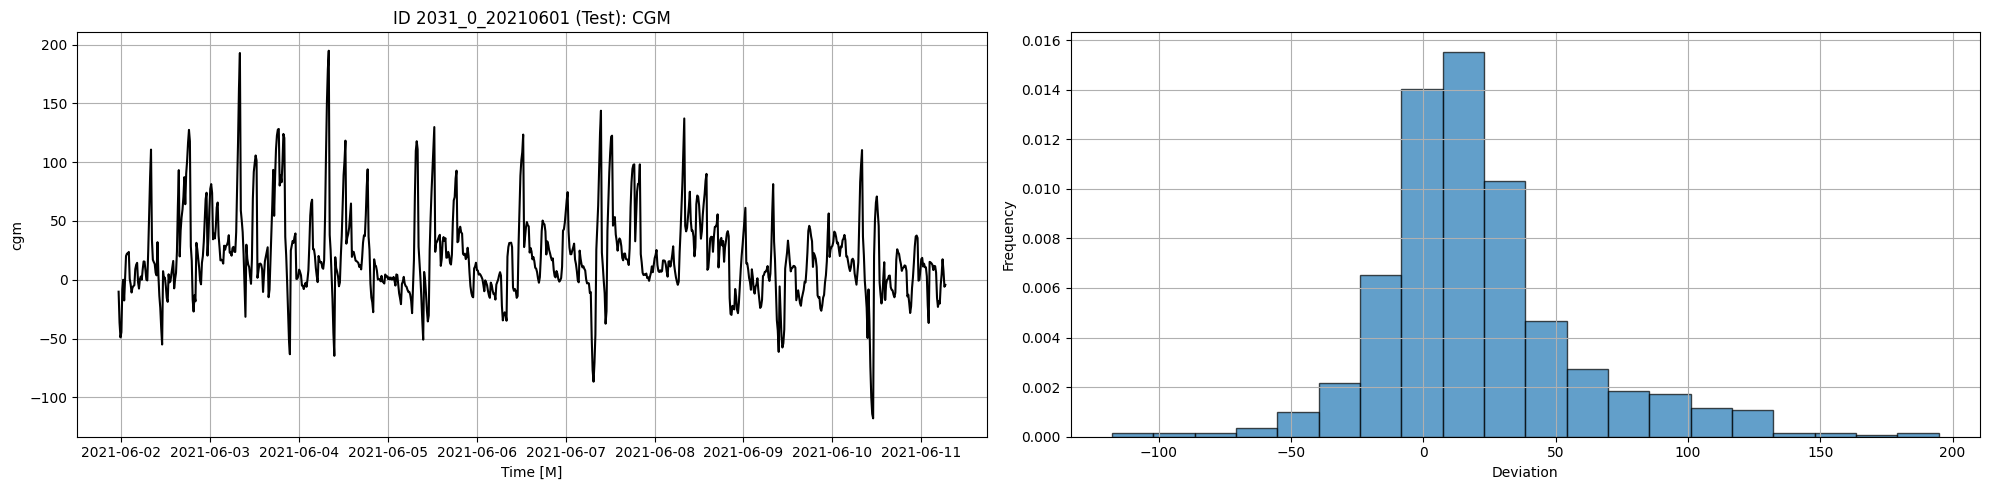

In [139]:
module_2.plot_residuals(id = id)

In [142]:
module_2.forecast(id = id)

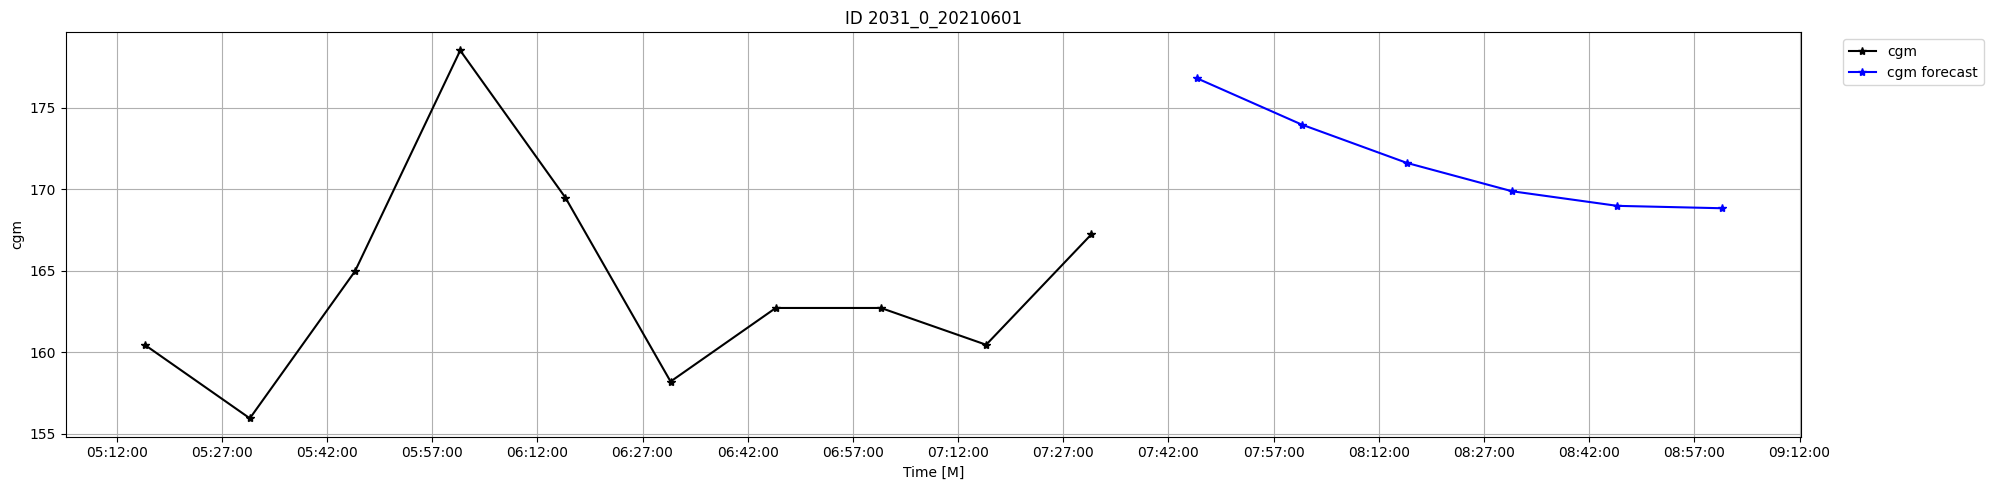

In [143]:
module_2.plot_forecast(figsize = (20, 5))

The predictive performance of the LSTM and CNN-LSTM models will very from session to session, but the second model should perform slightly better. For example, the first model yielded an RMSE of about 34.5 mg/dl and an R2 of about 0.7, while the second model resulted in an RMSE of 42.23 but an R2 of about 0.54.

Of course, more exploration should be done to find an optimal model this forecasting task. However, I hope this notebook provides a nice introduction to the [TorchTimeSeries](https://github.com/bchenley/TorchTimeSeries) package!